# Starbucks data analysis for marketing compaign
-data exploration and visualisation

-preprocessing and cleaning

-merging in 1 dataset

-preparing train,test data and labels

-different classifiers and their results

# Data Analysis and ML project
The GOAL is to respond to these questions:
1) what are the customers, their proportion in gender, income etc?
2) Do female customers complete offers more than male customers?
3) What are the customers ids that never view the offer
4) what offers are completed more BOGO or discount?
5) construct ML model that would predict if the offer will be completed or not

In [148]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
import json
import datetime
import matplotlib.pyplot as plt 
%matplotlib inline
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score
from bayes_opt import BayesianOptimization

In [2]:

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [3]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [4]:
portfolio.info()
print("data shape: ")
portfolio.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes
data shape: 


(10, 6)

In [5]:
#check for nan data
portfolio.isna().sum()

channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64

In [6]:
# checking for duplicates
print("duplicated :",portfolio.columns.duplicated().sum())
# checking if some id appear twice, how many unique offers?
print("unique offers: ",portfolio['id'].nunique())
#what are the offer types?
print("offer types: ",portfolio['offer_type'].unique())

duplicated : 0
unique offers:  10
offer types:  ['bogo' 'informational' 'discount']


In [7]:
portfolio.groupby('offer_type')['id'].count()

offer_type
bogo             4
discount         4
informational    2
Name: id, dtype: int64

### Profile

In [8]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [9]:
profile.info()
print("data shape: ")
profile.shape

# checking for duplicates
print("duplicated ids:",profile['id'].duplicated().sum())
#chcking for nan
print('nan values for income are: ',profile['income'].isna().sum())
print('gender type: ',profile['gender'].unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB
data shape: 
duplicated ids: 0
nan values for income are:  2175
gender type:  [None 'F' 'M' 'O']


M    57.23
F    41.34
O     1.43
Name: gender, dtype: float64


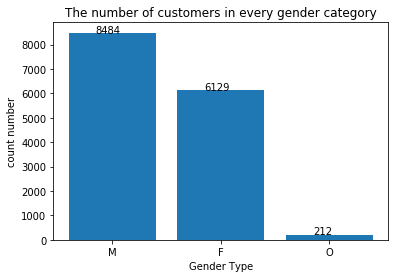

In [10]:
#bar plot for gender,income
a=profile['gender'].value_counts()
plt.bar(['M','F','O'],height=a)
plt.xlabel('Gender Type')
plt.ylabel('count number')
plt.title('The number of customers in every gender category')
xticks, xlabs=plt.xticks()
for i,v in enumerate(a):
    #print(i,' ',v)
    plt.text(i-0.15,v,str(v))
    #print(xticks[i])
#percentage
ratio_data=a/a.sum()
print(round(ratio_data*100,2))

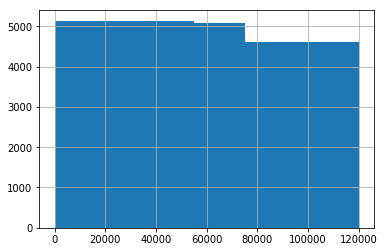

In [11]:

profile.income.hist(bins=[0,55000,75000,120000])

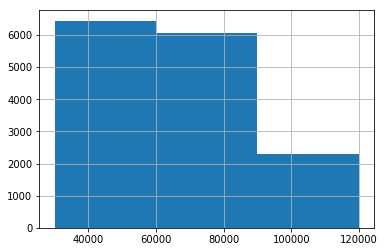

In [12]:
profile.income.hist(bins=3)

In [13]:
profile.income.describe()

count     14825.000000
mean      65404.991568
std       21598.299410
min       30000.000000
25%       49000.000000
50%       64000.000000
75%       80000.000000
max      120000.000000
Name: income, dtype: float64

In [14]:
# one way to determine groups kmeans = KMeans(n_clusters=4, random_state=0).fit(profile.income)
print("income 50.000 :",profile.id[profile['income']==50000].count())
print("income 49.000 :",profile.id[profile['income']<=48000].count())
print("income 50.000 :",profile.id[profile['income']==50000].count())

income 50.000 : 253
income 49.000 : 3624
income 50.000 : 253


In [15]:
profile['age'].value_counts().sort_values(ascending=False)

118    2175
58      408
53      372
51      363
54      359
59      359
57      353
52      351
55      350
56      342
63      338
60      333
49      321
62      318
67      317
64      311
61      309
48      288
66      284
50      284
65      280
68      259
70      252
69      242
47      232
45      231
71      230
42      227
43      215
46      212
       ... 
22      131
30      131
29      129
23      126
35      118
81      118
79      117
80      116
31      113
82      105
83      102
84       83
18       70
85       70
87       66
88       64
86       54
89       53
90       52
91       47
92       40
94       33
93       29
95       22
97       13
100      12
96        8
98        5
99        5
101       5
Name: age, Length: 85, dtype: int64

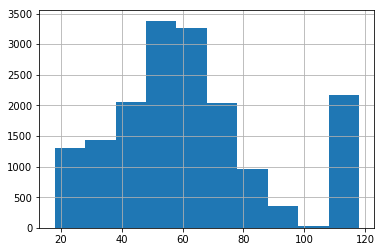

In [16]:
profile.age.hist()

In [17]:
df_outliers=profile[profile['age']==118]

print('missing gender: ',df_outliers.gender.isna().sum())
print('missing income: ',df_outliers.income.isna().sum())

missing gender:  2175
missing income:  2175


In [18]:
df_outliers.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN


### FIRST CONCLUSION

In [19]:
profile_processed=profile[profile['age']!=118]
profile_processed.head()

,age,became_member_on,gender,id,income
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0
12,58,20171111,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0


### TRANSCRIPT DATASET

In [20]:
transcript.head()


,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [21]:
transcript.info()
print("shape: ",transcript.shape)
print('missing values',transcript.columns.isna().sum())
print('time range',transcript.time.unique())
print('event type',transcript.event.unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB
shape:  (306534, 4)
missing values 0
time range [  0   6  12  18  24  30  36  42  48  54  60  66  72  78  84  90  96 102
 108 114 120 126 132 138 144 150 156 162 168 174 180 186 192 198 204 210
 216 222 228 234 240 246 252 258 264 270 276 282 288 294 300 306 312 318
 324 330 336 342 348 354 360 366 372 378 384 390 396 402 408 414 420 426
 432 438 444 450 456 462 468 474 480 486 492 498 504 510 516 522 528 534
 540 546 552 558 564 570 576 582 588 594 600 606 612 618 624 630 636 642
 648 654 660 666 672 678 684 690 696 702 708 714]
event type ['offer received' 'offer viewed' 'transaction' 'offer completed']


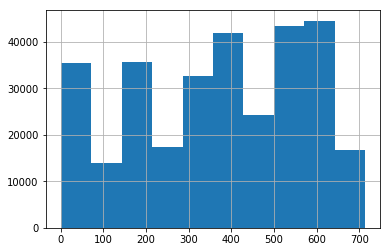

In [22]:
transcript.time.hist()

In [23]:
transcript.value.duplicated().sum()

301413

In [24]:
transcript[transcript.person=='78afa995795e4d85b5d9ceeca43f5fef']

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
15561,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
47582,transaction,78afa995795e4d85b5d9ceeca43f5fef,132,{'amount': 19.89}
47583,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,"{'reward': 5, 'offer_id': '9b98b8c7a33c4b65b9a..."
49502,transaction,78afa995795e4d85b5d9ceeca43f5fef,144,{'amount': 17.78}
53176,offer received,78afa995795e4d85b5d9ceeca43f5fef,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
85291,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,216,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
87134,transaction,78afa995795e4d85b5d9ceeca43f5fef,222,{'amount': 19.67}
92104,transaction,78afa995795e4d85b5d9ceeca43f5fef,240,{'amount': 29.72}
141566,transaction,78afa995795e4d85b5d9ceeca43f5fef,378,{'amount': 23.93}


In [25]:
#bogo
portfolio[portfolio.id=='ae264e3637204a6fb9bb56bc8210ddfd']#offer completed

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10


In [26]:
#informational
portfolio[portfolio.id=='5a8bc65990b245e5a138643cd4eb9837']#offer not completed

,channels,difficulty,duration,id,offer_type,reward
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0


transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64


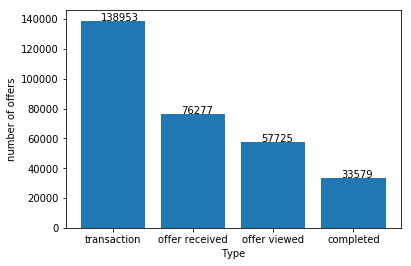

In [27]:
# transcript[transcript.value[262137].get('offer id')=='f19421c1d4aa40978ebb69ca19b0e20d']#0b1e1539f2cc45b7b9fa7c272da2e1d7
# type(transcript.value[0])
offers=transcript.event.value_counts()
print(offers)
plt.bar(['transaction','offer received','offer viewed','completed'],height=offers)
plt.xlabel('Type')
plt.ylabel('number of offers')
for k,v in enumerate(offers):
#     print(k)
    plt.text(k-0.15,v,str(v))

### QUESTIONS?
1) Does females or Males respond better to offers i.e view&complete

2) what are the ids of people that receive the offers but never view them

3) Are there some people that always complete the offers? In this case, do they do because they have a habit of spending?

In [28]:

#transcript.person[transcript['event']=='offer completed'&&transcript['event']=='offer completed']
ff=list()

In [29]:
portfolio_processed=portfolio.copy()
portfolio_processed.rename(columns={'id':'offer_id'},inplace=True)
#portfolio_processed.duration=portfolio_processed.duration*24

scaler=MinMaxScaler()#default =0.1
transform=['duration','difficulty','reward']
portfolio_processed[transform]=scaler.fit_transform(portfolio_processed[transform])

C:\Users\Admin\Anaconda3\envs\RoboND\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [30]:
portfolio_processed.head()

,channels,difficulty,duration,offer_id,offer_type,reward
0,"[email, mobile, social]",0.50,0.571429,ae264e3637204a6fb9bb56bc8210ddfd,bogo,1.0
1,"[web, email, mobile, social]",0.50,0.285714,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,1.0
2,"[web, email, mobile]",0.00,0.142857,3f207df678b143eea3cee63160fa8bed,informational,0.0
3,"[web, email, mobile]",0.25,0.571429,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,0.5
4,"[web, email]",1.00,1.000000,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,0.5


In [31]:
portfolio_processed['email']=portfolio_processed.channels.apply(lambda x: 1 if 'email' in x else 0)
portfolio_processed['mobile']=portfolio_processed.channels.apply(lambda x: 1 if 'mobile' in x else 0)
portfolio_processed['social']=portfolio_processed.channels.apply(lambda x: 1 if 'social' in x else 0)
portfolio_processed['web']=portfolio_processed.channels.apply(lambda x: 1 if 'web' in x else 0)
portfolio_processed.drop('channels',axis=1,inplace=True)
portfolio_processed.head()

,difficulty,duration,offer_id,offer_type,reward,email,mobile,social,web
0,0.50,0.571429,ae264e3637204a6fb9bb56bc8210ddfd,bogo,1.0,1,1,1,0
1,0.50,0.285714,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,1.0,1,1,1,1
2,0.00,0.142857,3f207df678b143eea3cee63160fa8bed,informational,0.0,1,1,0,1
3,0.25,0.571429,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,0.5,1,1,0,1
4,1.00,1.000000,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,0.5,1,0,0,1


In [32]:
# generate mapping for offer_id and replace
labels_offer=portfolio_processed['offer_id'].astype('category').cat.categories.tolist()
print(labels_offer)
mapping_labels_offer={'offer_id':{a:b for a,b in zip(labels_offer,list(range(1,len(labels_offer)+1)))}}
print(mapping_labels_offer)
portfolio_processed.replace(mapping_labels_offer,inplace=True)
portfolio_processed.head()

['0b1e1539f2cc45b7b9fa7c272da2e1d7', '2298d6c36e964ae4a3e7e9706d1fb8c2', '2906b810c7d4411798c6938adc9daaa5', '3f207df678b143eea3cee63160fa8bed', '4d5c57ea9a6940dd891ad53e9dbe8da0', '5a8bc65990b245e5a138643cd4eb9837', '9b98b8c7a33c4b65b9aebfe6a799e6d9', 'ae264e3637204a6fb9bb56bc8210ddfd', 'f19421c1d4aa40978ebb69ca19b0e20d', 'fafdcd668e3743c1bb461111dcafc2a4']
{'offer_id': {'3f207df678b143eea3cee63160fa8bed': 4, '0b1e1539f2cc45b7b9fa7c272da2e1d7': 1, '2906b810c7d4411798c6938adc9daaa5': 3, '9b98b8c7a33c4b65b9aebfe6a799e6d9': 7, 'fafdcd668e3743c1bb461111dcafc2a4': 10, '2298d6c36e964ae4a3e7e9706d1fb8c2': 2, 'ae264e3637204a6fb9bb56bc8210ddfd': 8, '5a8bc65990b245e5a138643cd4eb9837': 6, 'f19421c1d4aa40978ebb69ca19b0e20d': 9, '4d5c57ea9a6940dd891ad53e9dbe8da0': 5}}


,difficulty,duration,offer_id,offer_type,reward,email,mobile,social,web
0,0.50,0.571429,8,bogo,1.0,1,1,1,0
1,0.50,0.285714,5,bogo,1.0,1,1,1,1
2,0.00,0.142857,4,informational,0.0,1,1,0,1
3,0.25,0.571429,7,bogo,0.5,1,1,0,1
4,1.00,1.000000,1,discount,0.5,1,0,0,1


In [33]:
# generate mapping for offer_type and replace
mapping_offer_type={'bogo' : '1','informational':'2','discount':'3'}
portfolio_processed.replace(mapping_offer_type,inplace=True)
portfolio_processed.head()

,difficulty,duration,offer_id,offer_type,reward,email,mobile,social,web
0,0.50,0.571429,8,1,1.0,1,1,1,0
1,0.50,0.285714,5,1,1.0,1,1,1,1
2,0.00,0.142857,4,2,0.0,1,1,0,1
3,0.25,0.571429,7,1,0.5,1,1,0,1
4,1.00,1.000000,1,3,0.5,1,0,0,1


# Profile preprocessing

In [34]:
profile_processed=profile.copy()
profile_processed.rename(columns={'id':'person_id'},inplace=True)
profile_processed.dropna(inplace=True)

In [35]:
#type(profile_processed['age'])
#profile_processed['income'].apply(type)
profile_processed[['age','income']]=profile_processed[['age','income']].astype(int)
#generate mapping for scaling age
scaler=MinMaxScaler()#default =0.1
transform=['age','income']
profile_processed[transform]=scaler.fit_transform(profile_processed[transform])
profile_processed.head()

C:\Users\Admin\Anaconda3\envs\RoboND\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int32 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,age,became_member_on,gender,person_id,income
1,0.445783,20170715,F,0610b486422d4921ae7d2bf64640c50b,0.911111
3,0.686747,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,0.777778
5,0.602410,20180426,M,e2127556f4f64592b11af22de27a7932,0.444444
8,0.566265,20180209,M,389bc3fa690240e798340f5a15918d5c,0.255556
12,0.481928,20171111,M,2eeac8d8feae4a8cad5a6af0499a211d,0.233333


In [36]:

#mapping for person_id
prId=sorted(list(profile_processed['person_id']))
mapPersonId={k:v for k,v in zip(prId,list(range(1,len(prId)+1)))}
profile_processed['person_id'].replace(mapPersonId,inplace=True)


In [37]:
profile_processed['gender'].replace({'F':1,'M':2,'O':3},inplace=True)
profile_processed.head()

,age,became_member_on,gender,person_id,income
1,0.445783,20170715,1,347,0.911111
3,0.686747,20170509,1,6963,0.777778
5,0.602410,20180426,2,13108,0.444444
8,0.566265,20180209,2,3247,0.255556
12,0.481928,20171111,2,2670,0.233333


# strategy for preprocessing
became_member on will be transformed to how many days the client is a member and will be normalized with minMaxScaler

In [38]:
profile_processed['became_member_on'] = pd.to_datetime(profile_processed['became_member_on'], format = '%Y%m%d')
profile_processed['membership_days']= datetime.datetime.today().date() - profile_processed['became_member_on'].dt.date
scaler=MinMaxScaler()#default =0.1
transform=['membership_days']
profile_processed[transform]=scaler.fit_transform(profile_processed[transform])
profile_processed.head()


C:\Users\Admin\Anaconda3\envs\RoboND\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype timedelta64[ns] were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,age,became_member_on,gender,person_id,income,membership_days
1,0.445783,2017-07-15,1,347,0.911111,0.206253
3,0.686747,2017-05-09,1,6963,0.777778,0.243006
5,0.602410,2018-04-26,2,13108,0.444444,0.049918
8,0.566265,2018-02-09,2,3247,0.255556,0.091607
12,0.481928,2017-11-11,2,2670,0.233333,0.140976


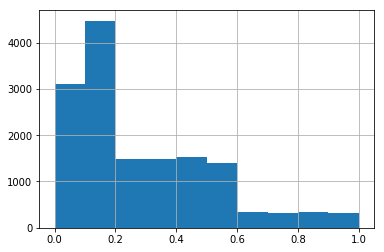

In [39]:
profile_processed.membership_days.hist()

# preprocessing transcript
strategy:
1) normalising 

In [40]:
transcript_processed=transcript.copy()
transcript_processed.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [41]:
transcript_processed.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [42]:
transcript_processed.value.describe()

count                                               306534
unique                                                5121
top       {'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
freq                                                 14983
Name: value, dtype: object

In [43]:
keys=[]
values=[]
for idx,row in transcript_processed.iterrows():
    for key,value in row['value'].items():
        if key not in keys:
            keys.append(key)
        if value not in values and len(str(value))==32:
            values.append(value)

In [44]:
keys

['offer id', 'amount', 'reward', 'offer_id']

In [45]:
values

['9b98b8c7a33c4b65b9aebfe6a799e6d9',
 '0b1e1539f2cc45b7b9fa7c272da2e1d7',
 '2906b810c7d4411798c6938adc9daaa5',
 'fafdcd668e3743c1bb461111dcafc2a4',
 '4d5c57ea9a6940dd891ad53e9dbe8da0',
 'f19421c1d4aa40978ebb69ca19b0e20d',
 '2298d6c36e964ae4a3e7e9706d1fb8c2',
 '3f207df678b143eea3cee63160fa8bed',
 'ae264e3637204a6fb9bb56bc8210ddfd',
 '5a8bc65990b245e5a138643cd4eb9837']

-leaving only offer viewed and completed and deleting all coresponding rows: offer ids

-since we are interested in view and completed offers

In [46]:
# for idx,row in transcript_processed.iterrows():
#     for value in row['event']:
#         if value=='transaction' or value=='offer received':
#             transcript_processed.event[idx]= NaN
transcript_processed['event'].replace({'offer received':np.NaN, 'transaction':np.NaN, '':np.NaN},inplace=True)

In [47]:
transcript_processed.head()

,event,person,time,value
0,NaN,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,NaN,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,NaN,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,NaN,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,NaN,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [48]:
print('number of nan element in event: ',transcript_processed.event.isnull().sum())
print('shape before dropping: ',transcript_processed.shape)
transcript_processed.dropna(how='any',axis=0,inplace=True)

transcript_processed.head()

number of nan element in event:  215230
shape before dropping:  (306534, 4)


,event,person,time,value
12650,offer viewed,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
12651,offer viewed,d1ede868e29245ea91818a903fec04c6,0,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
12652,offer viewed,102e9454054946fda62242d2e176fdce,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
12653,offer viewed,02c083884c7d45b39cc68e1314fec56c,0,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}
12655,offer viewed,be8a5d1981a2458d90b255ddc7e0d174,0,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}


In [49]:
print('after eliminating:',transcript_processed.shape)

after eliminating: (91304, 4)


In [50]:
# the normal form is {'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}, for some reason in some cases only id is present so we keep it
    transcript_processed['reward']=np.NaN
    for ids,row in transcript_processed.iterrows():
        try:
            if 'offer_id' in row['value'].keys():
                transcript_processed.at[ids,'offer_id']=row['value']['offer_id']
                
            else:
                transcript_processed.at[ids,'offer_id']=row['value']['offer id']
            if 'reward' in row['value'].keys():
                    transcript_processed.at[ids,'reward']=row['value']['reward']
        except:
            print(row['value'])
            print(ids)

In [51]:
transcript_processed.iloc[0,3]

{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}

In [52]:
# transcript_processed.replace(mapPersonId,inplace=True)
# print(profile_processed.dtypes)
transcript_processed.rename(columns={'person':'person_id'},inplace=True)
transcript_processed.replace(mapPersonId,inplace=True)

In [53]:
transcript_processed.drop(['value'],axis=1,inplace=True)#dropping initial column
transcript_processed.head()

,event,person_id,time,reward,offer_id
12650,offer viewed,3247,0,NaN,f19421c1d4aa40978ebb69ca19b0e20d
12651,offer viewed,12182,0,NaN,5a8bc65990b245e5a138643cd4eb9837
12652,offer viewed,922,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0
12653,offer viewed,149,0,NaN,ae264e3637204a6fb9bb56bc8210ddfd
12655,offer viewed,11108,0,NaN,5a8bc65990b245e5a138643cd4eb9837


In [54]:
transcript_processed.rename(columns={'client_id':'offer_id'},inplace=True)


In [55]:
labels_event = transcript_processed['event'].astype('category').cat.categories.tolist()
replace_map_comp_event = {'event' : {k: v for k,v in zip(labels_event,list(range(1,len(labels_event)+1)))}}
transcript_processed.replace(replace_map_comp_event, inplace=True)
transcript_processed.replace(mapping_labels_offer, inplace=True)
transcript_processed.head()

,event,person_id,time,reward,offer_id
12650,2,3247,0,NaN,9
12651,2,12182,0,NaN,6
12652,2,922,0,NaN,5
12653,2,149,0,NaN,8
12655,2,11108,0,NaN,6


In [56]:
transcript_processed.event.unique()

array([2, 1], dtype=int64)

# remark
in order to obtain viewed and completed we need to erase all the raws in dataframe that has the same analog in terms of person_id and offer_id, but are completed.

In [57]:
transcript_processed[(transcript_processed.person_id==3247) & (transcript_processed.offer_id==9)]

,event,person_id,time,reward,offer_id
12650,2,3247,0,NaN,9
32626,1,3247,60,5.0,9
214275,2,3247,504,NaN,9
271781,1,3247,600,5.0,9


In [58]:
#basic logic that we iterate from bottom up and if we see 2 in an event we remove it and replace the first '1' with 2 that we see and we restart
transcript_processed.shape

(91304, 5)

In [59]:
# 1 -remove all the outliers that we removed during processing profile with age 118
# ids=transcript_processed[len(transcript_processed.person_id)>7].index
for ids,row in transcript_processed.iterrows():
      if len(str(row.person_id))>7:
        transcript_processed.drop(ids,axis=0,inplace=True)

            

In [60]:
transcript_processed=transcript_processed.reset_index()

In [61]:

test_completion = pd.merge(
                    transcript_processed[transcript_processed['event'] == 2]
                    , transcript_processed[transcript_processed['event'] == 1]
                    , how = 'left'
                    , left_on = ['person_id','offer_id']
                    , right_on = ['person_id','offer_id']
        )

In [74]:
test_completion.head()

,index_x,event_x,person_id,time_x,reward_x,offer_id,index_y,event_y,time_y,reward_y
0,12650,2,3247,0,NaN,9,32626.0,1.0,60.0,5.0
1,12650,2,3247,0,NaN,9,271781.0,1.0,600.0,5.0
2,12651,2,12182,0,NaN,6,NaN,NaN,NaN,NaN
3,12652,2,922,0,NaN,5,15564.0,1.0,6.0,10.0
4,12653,2,149,0,NaN,8,NaN,NaN,NaN,NaN


In [63]:
transcript_processed[(transcript_processed.person_id==3247) & (transcript_processed.offer_id==9)]

,index,event,person_id,time,reward,offer_id
0,12650,2,3247,0,NaN,9
9557,32626,1,3247,60,5.0,9
53082,214275,2,3247,504,NaN,9
73218,271781,1,3247,600,5.0,9


In [64]:
test_completion[(test_completion.person_id==3247) & (test_completion.offer_id==9)]

,index_x,event_x,person_id,time_x,reward_x,offer_id,index_y,event_y,time_y,reward_y
0,12650,2,3247,0,NaN,9,32626.0,1.0,60.0,5.0
1,12650,2,3247,0,NaN,9,271781.0,1.0,600.0,5.0
38773,214275,2,3247,504,NaN,9,32626.0,1.0,60.0,5.0
38774,214275,2,3247,504,NaN,9,271781.0,1.0,600.0,5.0


In [65]:
transcript_processed.shape

(82304, 6)

In [66]:
transcript_processed[(transcript_processed.person_id==3247)]

,index,event,person_id,time,reward,offer_id
0,12650,2,3247,0,NaN,9
9557,32626,1,3247,60,5.0,9
19451,77212,2,3247,192,NaN,7
32467,132803,2,3247,354,NaN,3
46972,179953,2,3247,438,NaN,7
52783,200085,1,3247,498,2.0,3
52784,200086,1,3247,498,5.0,7
53082,214275,2,3247,504,NaN,9
70266,265621,2,3247,588,NaN,10
73218,271781,1,3247,600,5.0,9


In [67]:
test_completion[(test_completion.person_id==3247)]

,index_x,event_x,person_id,time_x,reward_x,offer_id,index_y,event_y,time_y,reward_y
0,12650,2,3247,0,NaN,9,32626.0,1.0,60.0,5.0
1,12650,2,3247,0,NaN,9,271781.0,1.0,600.0,5.0
15756,77212,2,3247,192,NaN,7,200086.0,1.0,498.0,5.0
24948,132803,2,3247,354,NaN,3,200085.0,1.0,498.0,2.0
35759,179953,2,3247,438,NaN,7,200086.0,1.0,498.0,5.0
38773,214275,2,3247,504,NaN,9,32626.0,1.0,60.0,5.0
38774,214275,2,3247,504,NaN,9,271781.0,1.0,600.0,5.0
51528,265621,2,3247,588,NaN,10,271782.0,1.0,600.0,2.0


In [68]:
tt=portfolio[['id','duration']]
tt.rename(columns={'id':'offer_id'},inplace=True)
tt.replace(mapping_labels_offer,inplace=True)
tt

C:\Users\Admin\Anaconda3\envs\RoboND\lib\site-packages\pandas\core\frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
C:\Users\Admin\Anaconda3\envs\RoboND\lib\site-packages\pandas\core\generic.py:5821: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  regex=regex)


,offer_id,duration
0,8,7
1,5,5
2,4,4
3,7,7
4,1,10
5,2,7
6,10,10
7,6,3
8,9,5
9,3,7


In [69]:
tt['duration']=tt['duration']*24
dur_completion=test_completion.merge(tt,how='left',on='offer_id')
dur_completion.head()

C:\Users\Admin\Anaconda3\envs\RoboND\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,index_x,event_x,person_id,time_x,reward_x,offer_id,index_y,event_y,time_y,reward_y,duration
0,12650,2,3247,0,NaN,9,32626.0,1.0,60.0,5.0,120
1,12650,2,3247,0,NaN,9,271781.0,1.0,600.0,5.0,120
2,12651,2,12182,0,NaN,6,NaN,NaN,NaN,NaN,72
3,12652,2,922,0,NaN,5,15564.0,1.0,6.0,10.0,120
4,12653,2,149,0,NaN,8,NaN,NaN,NaN,NaN,168


In [80]:
ipd=dur_completion[(((dur_completion.time_y-dur_completion.time_x)<dur_completion.duration) & (dur_completion.time_y>dur_completion.time_x)) | (dur_completion.time_y.isnull())]

In [87]:
ipd.fillna(0,inplace=True)
ipd.head() # 

C:\Users\Admin\Anaconda3\envs\RoboND\lib\site-packages\pandas\core\frame.py:3790: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


,index_x,event_x,person_id,time_x,reward_x,offer_id,index_y,event_y,time_y,reward_y
0,12650,2,3247,0,0.0,9,32626.0,1.0,60.0,5.0
2,12651,2,12182,0,0.0,6,0.0,0.0,0.0,0.0
3,12652,2,922,0,0.0,5,15564.0,1.0,6.0,10.0
4,12653,2,149,0,0.0,8,0.0,0.0,0.0,0.0
5,12655,2,11108,0,0.0,6,0.0,0.0,0.0,0.0


# we have sucessfully eliminated outliers ex: ind 2 and we take event_y as our labels for binary classification

In [91]:
print(ipd.shape)# Making sure that we dont add any additional row
master=ipd.merge(portfolio_processed,how='left',on='offer_id')
print(master.shape)

(42941, 10)
(42941, 18)


In [92]:
print(master.shape)# Making sure that we dont add any additional row
master=master.merge(profile_processed,how='left',on='person_id')
print(master.shape)

(42941, 18)
(42941, 23)


In [93]:
master.head()

,index_x,event_x,person_id,time_x,reward_x,offer_id,index_y,event_y,time_y,reward_y,...,reward,email,mobile,social,web,age,became_member_on,gender,income,membership_days
0,12650,2,3247,0,0.0,9,32626.0,1.0,60.0,5.0,...,0.5,1,1,1,1,0.566265,2018-02-09,2,0.255556,0.091607
1,12651,2,12182,0,0.0,6,0.0,0.0,0.0,0.0,...,0.0,1,1,1,0,0.421687,2017-09-16,3,0.244444,0.171695
2,12652,2,922,0,0.0,5,15564.0,1.0,6.0,10.0,...,1.0,1,1,1,1,0.614458,2016-08-14,1,0.300000,0.390016
3,12653,2,149,0,0.0,8,0.0,0.0,0.0,0.0,...,1.0,1,1,1,0,0.024096,2016-07-11,1,0.000000,0.408667
4,12655,2,11108,0,0.0,6,0.0,0.0,0.0,0.0,...,0.0,1,1,1,0,0.253012,2014-05-27,2,0.233333,0.834339


In [95]:
master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42941 entries, 0 to 42940
Data columns (total 23 columns):
index_x             42941 non-null int64
event_x             42941 non-null int64
person_id           42941 non-null int64
time_x              42941 non-null int64
reward_x            42941 non-null float64
offer_id            42941 non-null int64
index_y             42941 non-null float64
event_y             42941 non-null float64
time_y              42941 non-null float64
reward_y            42941 non-null float64
difficulty          42941 non-null float64
duration            42941 non-null float64
offer_type          42941 non-null object
reward              42941 non-null float64
email               42941 non-null int64
mobile              42941 non-null int64
social              42941 non-null int64
web                 42941 non-null int64
age                 42941 non-null float64
became_member_on    42941 non-null datetime64[ns]
gender              42941 non-null int64
in

## we want event_y as 1 column then the table except certains columns as became_member_on(redundant with membership_days) etc

In [114]:
master_data=master.drop(['became_member_on','index_x','index_y','event_x','time_y','reward_x','reward_y'], axis=1)
master_data['offer_type']=master_data['offer_type'].astype(int)
master_data.head()

,person_id,time_x,offer_id,event_y,difficulty,duration,offer_type,reward,email,mobile,social,web,age,gender,income,membership_days
0,3247,0,9,1.0,0.25,0.285714,1,0.5,1,1,1,1,0.566265,2,0.255556,0.091607
1,12182,0,6,0.0,0.00,0.000000,2,0.0,1,1,1,0,0.421687,3,0.244444,0.171695
2,922,0,5,1.0,0.50,0.285714,1,1.0,1,1,1,1,0.614458,1,0.300000,0.390016
3,149,0,8,0.0,0.50,0.571429,1,1.0,1,1,1,0,0.024096,1,0.000000,0.408667
4,11108,0,6,0.0,0.00,0.000000,2,0.0,1,1,1,0,0.253012,2,0.233333,0.834339


In [115]:
train_test_x=master_data.drop(['event_y'],axis=1)
train_test_y=master_data[['event_y']].astype(int)
train_test_y.head()

,event_y
0,1
1,0
2,1
3,0
4,0


In [116]:
train_test_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42941 entries, 0 to 42940
Data columns (total 15 columns):
person_id          42941 non-null int64
time_x             42941 non-null int64
offer_id           42941 non-null int64
difficulty         42941 non-null float64
duration           42941 non-null float64
offer_type         42941 non-null int32
reward             42941 non-null float64
email              42941 non-null int64
mobile             42941 non-null int64
social             42941 non-null int64
web                42941 non-null int64
age                42941 non-null float64
gender             42941 non-null int64
income             42941 non-null float64
membership_days    42941 non-null float64
dtypes: float64(6), int32(1), int64(8)
memory usage: 5.1 MB


#### separating the Union of 3 datasets in train and test ->SUPERVISED LEARNING

In [117]:
# creating training and testing sets 
X_train, X_test, y_train, y_test = train_test_split(train_test_x.values, train_test_y.values,train_size=0.8)

C:\Users\Admin\Anaconda3\envs\RoboND\lib\site-packages\sklearn\model_selection\_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [118]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(34352, 15)
(8589, 15)
(34352, 1)
(8589, 1)


# TRAINING
## We define metrics from sklearn and implement various binary classifiers, afterwards we choose 1 to implement bayesian optimisation

In [132]:

# defining a function to calculate the accuracy for the models we will try below 
def predict_score(model):
    pred = model.predict(X_test)
    accuracy=accuracy_score(y_test,pred)
    recall=recall_score(y_test,pred)
    precision=precision_score(y_test,pred)
    
    return accuracy,recall,precision

In [136]:

svm = LinearSVC(random_state=0, tol=1e-5)

svm.fit(X_train, y_train)
print('Accuracy of SVM classifier on training set: ',round(svm.score(X_train, y_train)*100,2))
print('Prediction Accuracy: ',predict_score(svm))

C:\Users\Admin\Anaconda3\envs\RoboND\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy of SVM classifier on training set:  68.06
Prediction Accuracy:  (0.6716730702060776, 0.475478748248482, 0.7800766283524905)


C:\Users\Admin\Anaconda3\envs\RoboND\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [144]:
rf = RandomForestClassifier(n_estimators = 1024, random_state = 42)

rf.fit(X_train, y_train)
print('Accuracy of SVM classifier on training set: ',round(rf.score(X_train, y_train)*100,2))
[accuracy,recall,precision]=predict_score(rf)
print('Prediction Accuracy: ',accuracy)
print('Prediction recall: ',recall)
print('Prediction precision: ',precision)

C:\Users\Admin\Anaconda3\envs\RoboND\lib\site-packages\ipykernel\__main__.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


Accuracy of SVM classifier on training set:  100.0
Prediction Accuracy:  0.8190709046454768
Prediction recall:  0.8383932741709481
Prediction precision:  0.8063791554357592


In [138]:
KN = KNeighborsClassifier()

KN.fit(X_train, y_train)
print('Accuracy of SVM classifier on training set: ',round(KN.score(X_train, y_train)*100,2))
[accuracy,recall,precision]=predict_score(KN)
print('Prediction Accuracy: ',accuracy)

C:\Users\Admin\Anaconda3\envs\RoboND\lib\site-packages\ipykernel\__main__.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  app.launch_new_instance()


Accuracy of SVM classifier on training set:  69.63
Prediction Accuracy:  0.5222959599487716


In [139]:
dt=DecisionTreeClassifier()
dt.fit(X_train, y_train)
print('Accuracy of SVM classifier on training set: ',round(dt.score(X_train, y_train)*100,2))
[accuracy,recall,precision]=predict_score(dt)
print('Prediction Accuracy: ',accuracy)

Accuracy of SVM classifier on training set:  100.0
Prediction Accuracy:  0.7743625567586447


In [145]:

gb = GradientBoostingClassifier()

gb.fit(X_train, y_train)
print('Accuracy of SVM classifier on training set: ',round(gb.score(X_train, y_train)*100,2))
[accuracy,recall,precision]=predict_score(gb)
print('Prediction Accuracy: ',accuracy)
print('Prediction recall: ',recall)
print('Prediction precision: ',precision)

C:\Users\Admin\Anaconda3\envs\RoboND\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy of SVM classifier on training set:  80.82
Prediction Accuracy:  0.8103388054488299
Prediction recall:  0.8435310602522186
Prediction precision:  0.7901990811638591


In [126]:
print(len(y_pred))
print(y_pred.sum())

8589
1709


# Bayesian optimisation of XGBoost

In [225]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss
from sklearn.metrics import make_scorer
#from bayes import BayesianOptimization
from bayes_opt import BayesianOptimization
#Bayesian optimization

parameters = {"n_estimators": (10, 1000),
                  "max_depth": (1, 150),
                  "min_samples_split": (2, 10)}
########################### Define Random Forest Optimization ###################
def rfccv(n_estimators, min_samples_split, max_depth):
    rf = RandomForestClassifier(n_estimators=int(n_estimators),
             min_samples_split=int(min_samples_split),
             max_depth=int(max_depth),
             random_state=2,
             n_jobs=-1)
    rf.fit(X_train, y_train)
    return -log_loss(y_test, rf.predict_proba(X_test)[:,1])

In [226]:
#Train model
def train(X_train, y_train, X_test, y_test, function, parameters):
    dataset = (X_train, y_train, X_test, y_test)
    
    rfcBO = BayesianOptimization(rfccv, parameters)
    # Change the values below to run for longer and getting better results.
    gp_params = {"alpha": 1e-4}
    n_iterations = 5
    rfcBO.maximize(n_iter=n_iterations, **gp_params)
    params = rfcBO.max['params']

    model = RandomForestClassifier(
             n_estimators=int(max(params["n_estimators"], 0)),
             max_depth=int(max(params["max_depth"], 1)),
             min_samples_split=int(max(params["min_samples_split"], 2)), 
             n_jobs=-1, 
             random_state=42,   
             class_weight="balanced")

    model.fit(X_train, y_train)
    
    return model

In [227]:
cv_splits = 4
best=train(X_train, y_train, X_test, y_test, rfccv, parameters)
predict_score(best)

|   iter    |  target   | max_depth | min_sa... | n_esti... |
-------------------------------------------------------------


C:\Users\Admin\Anaconda3\envs\RoboND\lib\site-packages\ipykernel\__main__.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


|  1        | -0.3642   |  127.8    |  3.265    |  498.2    |


C:\Users\Admin\Anaconda3\envs\RoboND\lib\site-packages\ipykernel\__main__.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


|  2        | -0.3641   |  87.42    |  3.55     |  557.4    |


C:\Users\Admin\Anaconda3\envs\RoboND\lib\site-packages\ipykernel\__main__.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


|  3        | -0.3654   |  94.87    |  5.113    |  892.1    |


C:\Users\Admin\Anaconda3\envs\RoboND\lib\site-packages\ipykernel\__main__.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


|  4        | -0.3641   |  116.8    |  3.596    |  565.1    |


C:\Users\Admin\Anaconda3\envs\RoboND\lib\site-packages\ipykernel\__main__.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


|  5        | -0.3638   |  59.7     |  4.229    |  943.3    |


C:\Users\Admin\Anaconda3\envs\RoboND\lib\site-packages\ipykernel\__main__.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


|  6        | -0.3865   |  10.75    |  7.162    |  10.73    |


C:\Users\Admin\Anaconda3\envs\RoboND\lib\site-packages\ipykernel\__main__.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


|  7        | -0.3794   |  11.53    |  6.203    |  999.9    |


C:\Users\Admin\Anaconda3\envs\RoboND\lib\site-packages\ipykernel\__main__.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


|  8        | -0.3654   |  145.3    |  5.26     |  997.9    |


C:\Users\Admin\Anaconda3\envs\RoboND\lib\site-packages\ipykernel\__main__.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


|  9        | -0.3657   |  144.0    |  6.281    |  998.2    |


C:\Users\Admin\Anaconda3\envs\RoboND\lib\site-packages\ipykernel\__main__.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


|  10       | -0.3669   |  148.3    |  7.744    |  998.8    |


C:\Users\Admin\Anaconda3\envs\RoboND\lib\site-packages\ipykernel\__main__.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


(0.8180230527418791, 0.838626809901915, 0.8046157293300471)

In [ ]:

    
#xgboost optimisation
def xgb_optimization(cv_splits, eval_set):
    def function(eta, gamma, max_depth):
            return cross_val_score(
                   xgb.XGBClassifier(
                       objective="binary:logistic",
                       learning_rate=max(eta, 0),
                       gamma=max(gamma, 0),
                       max_depth=int(max_depth),                                               
                       seed=42,
                       nthread=-1,
                       scale_pos_weight = len(y_train[y_train == 0])/
                                          len(y_train[y_train == 1])),  
                   X=X_train, 
                   y=y_train, 
                   cv=cv_splits,
                   scoring=precision_score,# large Negatives
                   fit_params={
                        "early_stopping_rounds": 10, 
                        "eval_metric": "auc", 
                        "eval_set": eval_set},
                   n_jobs=-1).mean()

    parameters = {"eta": (0.001, 0.4),
                  "gamma": (0, 20),
                  "max_depth": (1, 2000)}
    
    return function, parameters

In [ ]:
# # GridSearchCV credits to https://mlfromscratch.com/gridsearch-keras-sklearn/#/
# def algorithm_pipeline(X_train_data, X_test_data, y_train_data, y_test_data, 
#                        model, param_grid, cv=10, scoring_fit='neg_mean_squared_error',
#                        do_probabilities = False):
#     gs = GridSearchCV(
#         estimator=model,
#         param_grid=param_grid, 
#         cv=cv, 
#         n_jobs=-1, 
#         scoring=scoring_fit,
#         verbose=2
#     )
#     fitted_model = gs.fit(X_train_data, y_train_data)
    
#     if do_probabilities:
#       pred = fitted_model.predict_proba(X_test_data)
#     else:
#       pred = fitted_model.predict(X_test_data)
    
#     return fitted_model, pred

# model = xgb.XGBRegressor()
# param_grid = {
#     'n_estimators': [400, 700, 1000],
#     'colsample_bytree': [0.7, 0.8],
#     'max_depth': [15,20,25],
#     'reg_alpha': [1.1, 1.2, 1.3],
#     'reg_lambda': [1.1, 1.2, 1.3],
#     'subsample': [0.7, 0.8, 0.9]
# }

# model, pred = algorithm_pipeline(X_train, X_test, y_train, y_test, model, 
#                                  param_grid, cv=5)

# # Root Mean Squared Error
# print(np.sqrt(-model.best_score_))
# print(model.best_params_)